In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
from src.regime_trading_pipeline import RegimeRotationStrategy, StrategyResult


def show_results(result: StrategyResult):
    print("Start date:", result.metrics["start_date"])
    print("End date:  ", result.metrics["end_date"])
    print("Duration:  ", (pd.to_datetime(result.metrics["end_date"]) - pd.to_datetime(result.metrics["start_date"])).days, "\n")
    for i, cnt in enumerate(np.bincount(result.signal_series)):
        print("# of points in cluster", i, ":", cnt)

    df_list = [result.metrics]
    for item in result.benchmarks:
        df_list.append(RegimeRotationStrategy._compute_metrics(result.benchmarks[item].pct_change()))
    df = pd.DataFrame(df_list, index=["Strategy"] + list(result.benchmarks.keys()))
    df = df.drop(columns=["start_date", "end_date", "duration"])
    return df


def plot_results(result: StrategyResult, type: str):
    def max_drawdown_span(curve: pd.Series) -> tuple[pd.Timestamp, pd.Timestamp]:
        roll_max = curve.cummax()
        drawdown = curve / roll_max - 1
        trough = drawdown.idxmin()
        peak = curve.loc[:trough].idxmax()
        return peak, trough
    peak, trough = max_drawdown_span(result.equity_curve)

    _, (ax_equity, ax_weight) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), gridspec_kw={"height_ratios": (3, 1)})

    # top panel: equity curves
    ax_equity.plot(result.equity_curve.index, result.equity_curve, label="Strategy", zorder=100)
    ax_equity.axvspan(peak, trough, color="red", alpha=0.15)
    cols = ["gray", "darkgray", "lightgray", "tab:orange"]
    for i, (k, v) in enumerate(result.benchmarks.items()):
        ax_equity.plot(v.index, v, label=k, color=cols[i], zorder=-i)
    ax_equity.set_title(f"Equity Curve ({type})")
    ax_equity.grid(alpha=0.6)
    ax_equity.legend()

    # bottom panel: signal/weight series
    ax_weight.plot(result.weights.index, result.signal_series, color="green", lw=1)
    ax_weight.set_ylabel("Regimes")
    ax_weight.set_xlabel("Date")
    ax_weight.grid(alpha=0.6)

    plt.tight_layout()
    plt.show()

In [2]:
growth = [
    "ADBE", "CRM", "LULU", "ORLY", "COST",
    "TMO", "LIN", "ACN", "MA", "V",
    "SPGI", "MCO", "DHR", "SHW", "INTU",
    "NFLX", "NOW", "SNPS", "ISRG", "CDNS",
]

# Retrieved from https://www.simplysafedividends.com/world-of-dividends/posts/939-20-best-recession-proof-dividend-stocks-for-a-2025-downturn
defensive = [
    "EPD", "VZ", "O", "GIS", "BMY",
    "KMB", "CVX", "PSA", "PEP", "XOM",
    "DUK", "ED", "GPC", "WEC", "LMT",
    "KO", "PG", "JNJ", "CL", "MCD",
]

strategy = RegimeRotationStrategy(
    growth_tickers=growth,
    defensive_tickers=defensive,
    start_date="2019-05-09",  # 5 yrs data (post covid)
    p_dim=2,                  # W2 distance
    window=360,               # approx. 15 days hourly return
    step=12,                  # half a day
    refit_every=48,           # refit MK-means every 24 days
    shift=True,
)

strategy.fit_wkmeans()
strategy.build_returns()

Start date: 2020-10-30
End date:   2025-10-30
Duration:   1826 

# of points in cluster 0 : 663
# of points in cluster 1 : 356
# of points in cluster 2 : 237


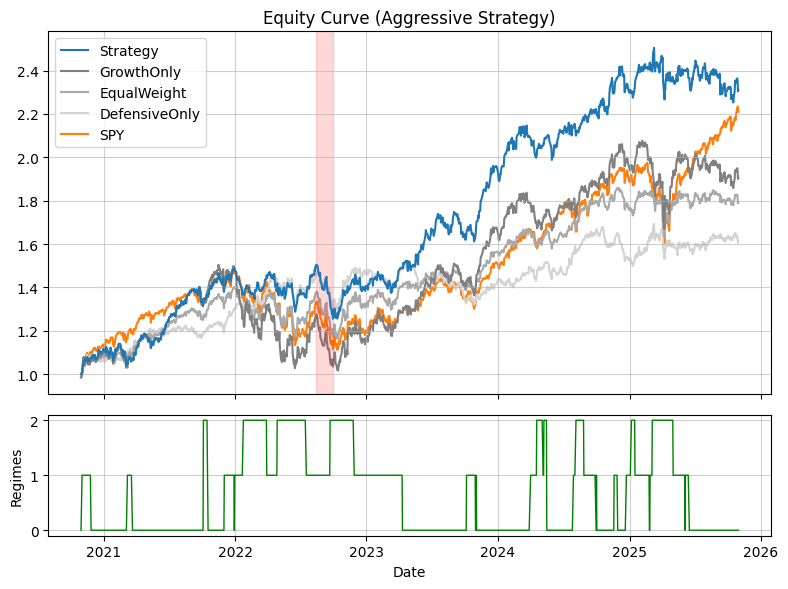

,cumulative_return,annual_return,annual_volatility,sharpe,max_drawdown
Strategy,1.310732,0.182991,0.151118,1.210920,-0.165468
GrowthOnly,0.937040,0.141854,0.207817,0.682590,-0.324234
EqualWeight,0.809958,0.126413,0.140871,0.897372,-0.170234
DefensiveOnly,0.615923,0.101075,0.121813,0.829759,-0.125564
SPY,1.233194,0.174918,0.171519,1.019819,-0.244964


In [3]:
result = strategy.backtest(
    allocations={
        0: {"growth": 1.0, "defensive": 0.0},
        1: {"growth": 0.5, "defensive": 0.5},
        2: {"growth": 0.0, "defensive": 1.0},
    },
)

df = show_results(result)
plot_results(result, "Aggressive Strategy")
df

Start date: 2020-10-30
End date:   2025-10-30
Duration:   1826 

# of points in cluster 0 : 663
# of points in cluster 1 : 356
# of points in cluster 2 : 237


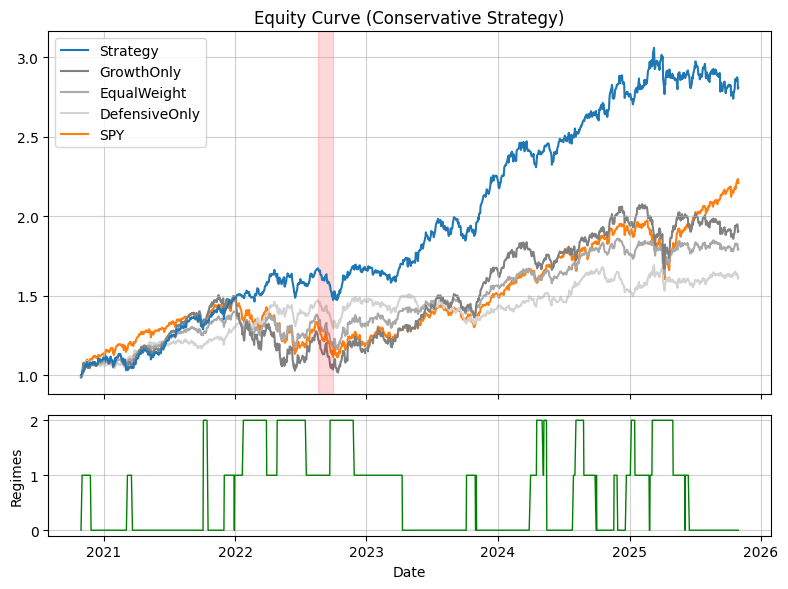

,cumulative_return,annual_return,annual_volatility,sharpe,max_drawdown
Strategy,1.810712,0.230408,0.146633,1.571328,-0.119491
GrowthOnly,0.937040,0.141854,0.207817,0.682590,-0.324234
EqualWeight,0.809958,0.126413,0.140871,0.897372,-0.170234
DefensiveOnly,0.615923,0.101075,0.121813,0.829759,-0.125564
SPY,1.233194,0.174918,0.171519,1.019819,-0.244964


In [4]:
result = strategy.backtest(
    allocations={
        0: {"growth": 1.0, "defensive": 0.0},
        1: {"growth": 0.0, "defensive": 1.0},
        2: {"growth": 0.0, "defensive": 1.0},
    },
)

df = show_results(result)
plot_results(result, "Conservative Strategy")
df

In [ ]:
df = RegimeRotationStrategy.grid_search_regimes(
    growth,
    defensive,
    start_date="2019-05-09",
    windows=(36, 72, 120, 240, 360, 480),
    steps=(6, 12, 24, 48),
    refits=(12, 24, 48, 96, 120),
)
df

Output()

start_date    end_date  duration  \
p window step refit_every                                     
2 360    12   48           2020-10-30  2025-10-30      1826   
              24           2020-10-30  2025-10-30      1826   
              120          2020-10-30  2025-10-30      1826   
              96           2020-10-30  2025-10-30      1826   
              12           2020-10-30  2025-10-30      1826   
...                               ...         ...       ...   
         48   96           2025-02-05  2025-10-30       267   
              12           2025-02-05  2025-10-30       267   
              24           2025-02-05  2025-10-30       267   
              48           2025-02-05  2025-10-30       267   
              120          2025-02-05  2025-10-30       267   

                           cumulative_return  annual_return  \
p window step refit_every                                     
2 360    12   48                    1.810712       0.230408   
              24                    1.791224       0.228692   
              120                   1.759696       0.225894   
              96                    1.746834       0.224746   
              12                    1.612305       0.212468   
...                                      ...            ...   
         48   96                   -0.226053      -0.293322   
              12                   -0.226053      -0.293322   
              24                   -0.226053      -0.293322   
              48                   -0.226053      -0.293322   
              120                  -0.226053      -0.293322   

                           annual_volatility    sharpe  max_drawdown  
p window step refit_every                                             
2 360    12   48                    0.146633  1.571328     -0.119491  
              24                    0.147499  1.550460     -0.119491  
              120                   0.146580  1.541102     -0.119491  
              96                    0.147231  1.526481     -0.119491  
              12                    0.147956  1.436027     -0.123013  
...                                      ...       ...           ...  
         48   96                    0.173418 -1.691418     -0.245345  
              12                    0.173418 -1.691418     -0.245345  
              24                    0.173418 -1.691418     -0.245345  
              48                    0.173418 -1.691418     -0.245345  
              120                   0.173418 -1.691418     -0.245345  

[120 rows x 8 columns]